<a href="https://www.kaggle.com/code/priyanagda/rite-unet-using-pytorch?scriptVersionId=95792012" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg

In [2]:
torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed_all(42)

In [3]:
class conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()
    
    def forward(self, images):
        x = self.conv1(images)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x


In [4]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = conv(in_channels, out_channels)
        self.pool = nn.MaxPool2d((2,2))

    def forward(self, images):
        x = self.conv(images)
        p = self.pool(x)

        return x, p

In [5]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = conv(out_channels * 2, out_channels)

    def forward(self, images, prev):
        x = self.upconv(images)
        x = torch.cat([x, prev], axis=1)
        x = self.conv(x)

        return x


In [6]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.e1 = encoder(3, 64)
        self.e2 = encoder(64, 128)
        self.e3 = encoder(128, 256)
        self.e4 = encoder(256, 512)

        self.b = conv(512, 1024)

        self.d1 = decoder(1024, 512)
        self.d2 = decoder(512, 256)
        self.d3 = decoder(256, 128)
        self.d4 = decoder(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, images):
        x1, p1 = self.e1(images)
        x2, p2 = self.e2(p1)
        x3, p3 = self.e3(p2)
        x4, p4 = self.e4(p3)

        b = self.b(p4)
        
        d1 = self.d1(b, x4)
        d2 = self.d2(d1, x3)
        d3 = self.d3(d2, x2)
        d4 = self.d4(d3, x1)

        output_mask = torch.sigmoid(self.output(d4))

        return output_mask      

In [7]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = Image.open(self.masks_path[idx]).convert('L')
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [8]:
train_X = sorted(glob.glob('../input/ritedataset/train/images/*'))
train_y = sorted(glob.glob('../input/ritedataset/train/masks/*'))

test_X = sorted(glob.glob('../input/ritedataset/test/images/*'))
test_y = sorted(glob.glob('../input/ritedataset/test/masks/*'))

valid_X = sorted(glob.glob('../input/ritedataset/validation/images/*'))
valid_y = sorted(glob.glob('../input/ritedataset/validation/masks/*'))

In [9]:
len(test_X)

10

In [10]:
H = 512
W = 512
size = (H, W)
batch_size = 2
num_epochs = 50
lr = 1e-4
checkpoint_path = "./checkpoint.pth"

train_dataset = LoadData(train_X, train_y)
valid_dataset = LoadData(valid_X, valid_y)


In [11]:
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
)

In [12]:
device = torch.device('cuda')
model = UNet()
model = model.to(device)

In [13]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        loss = torch.nn.BCELoss()
        BCE = loss(inputs, targets)
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
loss_fn = DiceBCELoss()

In [15]:
def train_model(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
#         x,y=x.type(torch.FloatTensor),y.type(torch.FloatTensor)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [16]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
#             x,y=x.type(torch.DoubleTensor),y.type(torch.DoubleTensor)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [17]:
train = []
valid = []

best_valid_loss = float("inf")

for epoch in range(num_epochs):
        train_loss = train_model(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train.append(train_loss)
        valid.append(valid_loss)        
        
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model, checkpoint_path)

        data_str = f'Epoch: {epoch+1:02}\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        print(data_str)

Valid loss improved from inf to 1.2422. Saving checkpoint: ./checkpoint.pth
Epoch: 01
	Train Loss: 1.167
	 Val. Loss: 1.242

Valid loss improved from 1.2422 to 0.9348. Saving checkpoint: ./checkpoint.pth
Epoch: 02
	Train Loss: 0.980
	 Val. Loss: 0.935

Valid loss improved from 0.9348 to 0.8839. Saving checkpoint: ./checkpoint.pth
Epoch: 03
	Train Loss: 0.915
	 Val. Loss: 0.884

Valid loss improved from 0.8839 to 0.8642. Saving checkpoint: ./checkpoint.pth
Epoch: 04
	Train Loss: 0.871
	 Val. Loss: 0.864

Valid loss improved from 0.8642 to 0.8178. Saving checkpoint: ./checkpoint.pth
Epoch: 05
	Train Loss: 0.829
	 Val. Loss: 0.818

Valid loss improved from 0.8178 to 0.7857. Saving checkpoint: ./checkpoint.pth
Epoch: 06
	Train Loss: 0.796
	 Val. Loss: 0.786

Valid loss improved from 0.7857 to 0.7505. Saving checkpoint: ./checkpoint.pth
Epoch: 07
	Train Loss: 0.760
	 Val. Loss: 0.751

Valid loss improved from 0.7505 to 0.7231. Saving checkpoint: ./checkpoint.pth
Epoch: 08
	Train Loss: 0.729

In [18]:
test_dataset = LoadData(test_X, test_y)
test_loader = DataLoader(dataset=test_dataset, batch_size=2)

<Figure size 2160x576 with 0 Axes>

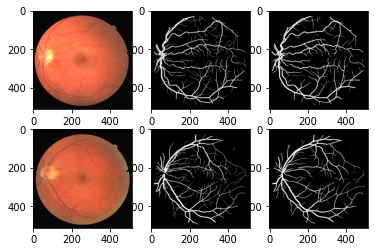

In [19]:
transform = transforms.ToPILImage()
for x, y in test_loader:
    image0 = transform(x[0])
    image1 = transform(x[1])

    x = x.to(device, dtype=torch.float32)
    y = y.to(device, dtype=torch.float32)
    
    y_pred = model(x)
    img = y_pred.cpu().detach().numpy()
    plt.figure(figsize=(30,8))

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(2,3) 

    axarr[0,0].imshow(image0)
    axarr[0,1].imshow(np.squeeze(y.cpu().detach().numpy())[0], cmap='gray')
    axarr[0,2].imshow(np.squeeze(img)[0], cmap='gray')
    
    axarr[1,0].imshow(image1)
    axarr[1,1].imshow(np.squeeze(y.cpu().detach().numpy())[1], cmap='gray')
    axarr[1,2].imshow(np.squeeze(img)[1], cmap='gray')
    break

In [20]:
test_loss = evaluate(model, test_loader, loss_fn, device)

In [21]:
test_loss

0.35259798765182493